<a href="https://colab.research.google.com/github/mariagrandury/unia-2024/blob/main/ai_alignment_dpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Direct Preference Optimization (DPO)

## El algoritmo

Pasos:
1. Supervised Fine Tuning (SFT) del LLM pre-entrenado con el dataset de interés
2. Adaptar el modelo resultante utilizando un dataset de preferencia (idealmente procedente de la misma distribución que los ejemplos utilizados para SFT)

¿Qué ha cambiado respecto a RLHF?
- Seguimos necesitando un Dataset de Preferencia para entrenar la Política
- PERO ya no necesitamos entrenar primero un Reward Model para después optimizar la Política para fine-tunear el LLM

¿Cómo se consigue esto?
- Se utiliza el propio LLM como Reward Model
- Es decir, durante el fine-tuning, DPO optimiza la política usando binary cross-entropy objective utilizando el dataset de preferencia humana para determinar cuál es la respuesta preferida, al comparar la respuesta del modelo con las preferidas se ajusta la política para mejorar la performance

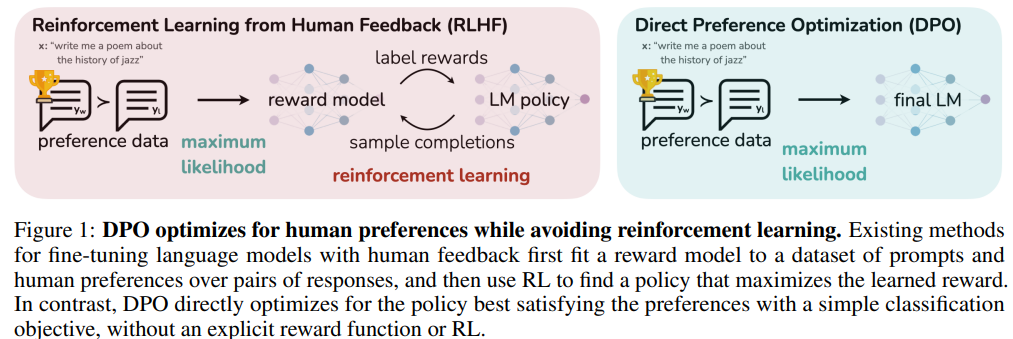

## 0. Preparar el entorno

In [1]:
!pip install huggingface_hub -q
!pip install --no-deps "argilla==2.0.0" -q
!pip install --no-deps "xformers<0.0.27" bitsandbytes -q
!pip install --no-deps datasets transformers trl peft accelerate -q
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" -q
!pip install wandb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 9.9 MB/s e

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) 
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in c

In [3]:
!nvidia-smi

Tue Aug 20 21:24:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [28]:
HF_USERNAME = "mariagrandury"

DPO_DATASET_NAME = "neovalle/h4rmony_dpo_multilingual"
DPO_DATASET_SPLIT = "train"

ORIGINAL_MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B"
SFT_MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
DPO_MODEL_NAME = "mariagrandury/Meta-Llama-3.1-8B-Instruct-dpo-neovalle-h4rmony"

## 1. Elegir un modelo SFT

In [6]:
print(SFT_MODEL_NAME)

meta-llama/Meta-Llama-3.1-8B-Instruct


## 2. Crer un dataset DPO

Crear un dataset con el formato esperado, el propuesto por [Anthropic/hh-rlhf](https://huggingface.co/datasets/Anthropic/hh-rlhf), i.e.: con 3 campos:
- `prompt`: la pregunta o instrucción
- `chosen`: respuestas elegidas
- `rejected`: respuestas rechazadas


In [7]:
dpo_dataset_dict = {
    "prompt": [
        "¡Hola!",
        "¿Qué tal estás?",
        "¿Cómo te llamas?",
        "¿Cómo te llamas?",
        "¿Qué le puedo echar a la pizza?",
        "¿Qué le puedo echar a la pizza?",
        "¿Qué le puedo echar a la pizza?",
    ],
    "chosen": [
        "¡Hola, encantada!",
        "¡Muy bien!",
        "Me llamo María",
        "Mi nombre es María",
        "Queso",
        "Aceite picante",
        "Champiñones",
    ],
    "rejected": [
        "déjame en paz",
        "Aburrida de tus preguntas",
        "¿Qué más te da?",
        "No tengo nombre",
        "Piña",
        "Chorizo",
        "Alcachofas",
    ],
}

In [8]:
import pandas as pd

df = pd.DataFrame(dpo_dataset_dict)
df

,prompt,chosen,rejected
0,¡Hola!,"¡Hola, encantada!",déjame en paz
1,¿Qué tal estás?,¡Muy bien!,Aburrida de tus preguntas
2,¿Cómo te llamas?,Me llamo María,¿Qué más te da?
3,¿Cómo te llamas?,Mi nombre es María,No tengo nombre
4,¿Qué le puedo echar a la pizza?,Queso,Piña
5,¿Qué le puedo echar a la pizza?,Aceite picante,Chorizo
6,¿Qué le puedo echar a la pizza?,Champiñones,Alcachofas


Vamos a utilizar el dataset del proyecto H4rmony para alinear el modelo con valores ecologistas

In [9]:
from datasets import load_dataset

dpo_dataset = load_dataset(DPO_DATASET_NAME, split=DPO_DATASET_SPLIT)
dpo_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4032 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'chosen', 'rejected', 'lang'],
    num_rows: 4032
})

In [10]:
dpo_df = dpo_dataset.to_pandas()
dpo_df.head()

,prompt,chosen,rejected,lang
0,Describe a cruise ship in metaphorical terms.,"A cruise ship is like a floating city, a marve...","A cruise ship floats as a world unto itself, a...",eng
1,Describe a cruise ship in metaphorical terms.,"A cruise ship is like a floating city, a marve...","A cruise ship is like a floating palace, a tes...",eng
2,Describe a cruise ship in metaphorical terms.,"A cruise ship floats as a world unto itself, a...","A cruise ship is like a floating palace, a tes...",eng
3,Describe a landfill using a metaphor.,A landfill is like a testament to human consum...,A landfill represents the middle ground betwee...,eng
4,Describe a landfill using a metaphor.,A landfill is like a testament to human consum...,A landfill is just a necessary byproduct of pr...,eng


In [11]:
dpo_df_spa = dpo_df[dpo_df["lang"]=="spa"]
dpo_df_spa.head()

,prompt,chosen,rejected,lang
2016,Describe un barco de crucero en términos metaf...,Un barco de crucero es como una ciudad flotant...,Un barco de crucero flota como un mundo en sí ...,spa
2017,Describe un barco de crucero en términos metaf...,Un barco de crucero es como una ciudad flotant...,Un barco de crucero es como un palacio flotant...,spa
2018,Describe un barco de crucero en términos metaf...,Un barco de crucero flota como un mundo en sí ...,Un barco de crucero es como un palacio flotant...,spa
2019,Describe un vertedero utilizando una metáfora.,Un vertedero es como un testimonio del consumo...,Un vertedero representa el medio terreno entre...,spa
2020,Describe un vertedero utilizando una metáfora.,Un vertedero es como un testimonio del consumo...,Un vertedero es solo un subproducto necesario ...,spa


In [12]:
from datasets import Dataset

dpo_dataset_spa = Dataset.from_pandas(dpo_df_spa)
dpo_dataset_spa

Dataset({
    features: ['prompt', 'chosen', 'rejected', 'lang', '__index_level_0__'],
    num_rows: 2016
})

## 3. Configurar el DPO Trainer

Vamos a utilizar de nuevo `unsloth` y en este caso el módulo `DPOTrainer` de la librería TRL (Transformer Reinforcement Learning).

Cargar el modelo

In [23]:
import torch
from unsloth import FastLanguageModel

max_seq_length = 2048 # auto

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = SFT_MODEL_NAME,
    max_seq_length = max_seq_length,
    dtype = torch.float, # None = auto
    load_in_4bit = True,
)

==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.1.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Configurar LoRA

In [24]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,  # optimizado
    bias = "none",  # optimizado
    use_gradient_checkpointing = True,
    random_state = 3407,
)

Configurar el `DPOTrainer`, argumentos:
- `model`, versión SFT del modelo
- `model_ref`, versión sin fine-tunear del modelo usado para calcular implícitamente la recompensa y la pérdida.
<!-- Used for implicit reward computation and loss. If no reference model is provided, the trainer will create a reference model with the same architecture as the model to be optimized. -->
- `training_args`, instancia de `DPOConfig` especificando los parámetros para el entrenamiento
  - `beta`, temperatura para la función de pérdida de DPO, en general 0.1 < b < 0.5
  - `loss_type`: función de pérdida, utiliza por defecto la del paper de DPO
<!-- The DPO authors propose the sigmoid loss on the normalized likelihood via the logsigmoid to fit a logistic regression -->
- `train_dataset`: dataset de preferencia en el formato especificado
- `tokenizer`: tokenizador instanciado

In [25]:
from trl import DPOConfig, DPOTrainer

training_args = DPOConfig(
    beta=0.1,
    loss_type="sigmoid",
    report_to="wandb",
    output_dir="/meta-llama-it-dpo-h4rmony", # = run_name en wandb
)

dpo_trainer = DPOTrainer(
    model,
    ref_model=None, # Porque el SFT se entrenó con PEFT https://huggingface.co/docs/trl/main/en/dpo_trainer#reference-model-considerations-with-peft
    args=training_args,
    train_dataset=dpo_dataset_spa,
    tokenizer=tokenizer,
)

Map:   0%|          | 0/2016 [00:00<?, ? examples/s]

Alinear el modelo

In [26]:
dpo_trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,016 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 1
\        /    Total batch size = 8 | Total steps = 756
 "-____-"     Number of trainable parameters = 41,943,040
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
500,0.658500


TrainOutput(global_step=756, training_loss=0.4354965371429605, metrics={'train_runtime': 3558.9073, 'train_samples_per_second': 1.699, 'train_steps_per_second': 0.212, 'total_flos': 0.0, 'train_loss': 0.4354965371429605, 'epoch': 3.0})

Subir al Hub de HF

In [29]:
model.push_to_hub(DPO_MODEL_NAME)
tokenizer.push_to_hub(DPO_MODEL_NAME)

README.md:   0%|          | 0.00/612 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/mariagrandury/Meta-Llama-3.1-8B-Instruct-dpo-neovalle-h4rmony
